# Physical preprocessing steps


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

## Orientation


At first we load the T1-weighted brain mri and extract the volume:

In [3]:
brain_mri = nib.load("IXI662-Guys-1120-T1.nii.gz")
brain_mri_data = brain_mri.get_fdata()

Then we extract its shape and affine matrix

In [4]:
shape = brain_mri.shape
affine = brain_mri.affine
print(affine)
print(shape)

[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(256, 256, 150)


In [5]:
affine[:, 3:]

array([[ -90.67985535],
       [ 102.82944489],
       [-114.82378387],
       [   1.        ]])

The **affine matrix** describes the mapping from **voxel (or pixel) coordinates** to **scanner (or world) coordinates**.  
It is always a $4 \times 4$ matrix with the following structure:

\[
\begin{bmatrix}
\color{red}{x_{1,1}} & \color{red}{x_{1,2}} & \color{red}{x_{1,3}} & \color{blue}{x_{1,4}} \\
\color{red}{x_{2,1}} & \color{red}{x_{2,2}} & \color{red}{x_{2,3}} & \color{blue}{x_{2,4}} \\
\color{red}{x_{3,1}} & \color{red}{x_{3,2}} & \color{red}{x_{3,3}} & \color{blue}{x_{3,4}} \\
\color{red}{0}        & \color{red}{0}        & \color{red}{0}        & \color{blue}{1}
\end{bmatrix}
\]

- The $\color{red}{\text{red}}$ **$3 \times 3$ submatrix** handles **rotation**, **scaling**, and **shearing**.
- The $\color{blue}{\text{blue}}$ **translation vector** provides the **offset** in world space.
- The final row `[0, 0, 0, 1]` allows for transformation using **homogeneous coordinates**, enabling all operations (linear + translation) via a single matrix multiplication.

The affine matrix is a combination of these transformations, enabling accurate spatial mapping of image data.


We can access the size of a voxel in the volume by using the **header.get_zooms()** function provided by nibabel.
It returns the size of a voxel in all directions in mm.

In [6]:
print(brain_mri.header.get_zooms())

(np.float32(0.9375), np.float32(0.9375), np.float32(1.2000039))


You can slice through the volume in all orientations: axial, coronal and sagittal.<br />
**NOTE: Depending on the orientation of the scan, the indices change**<br />
Sometimes the first axis slices axial, sometimes coronal and sometimes sagittal.

In [7]:
nib.aff2axcodes(affine)

('P', 'S', 'R')

In this case, the orientation of the scan is:
* **from anterior to posterior (from front to back)**
* **from inferior to superior (from bottom to top)**
* **from left to right**

The letters returned from aff2axcodes always indicate the end of the corresponding axis.

This also explains why the scan is upside down, when slicing along the fist axis (coronal). As the second axis moves from the bottom to the top, the first slice is **not** the top of the head, but some part of the neck.

Let's slice through all orientations to get a feeling for it:

At first we move along the first axis (anterior to posterior). This moves through the head from the face to the back of the head.<br /> **Coronal View**

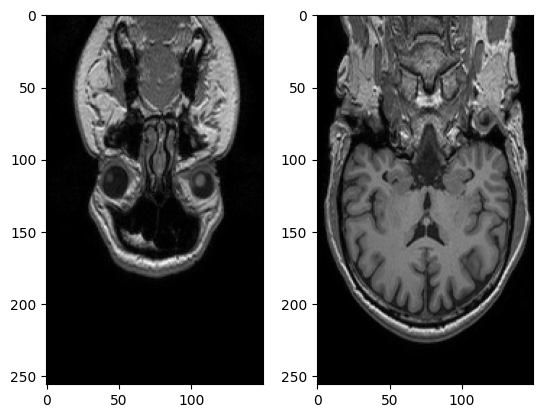

In [8]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_data[40, :, :], cmap="gray")
axis[1].imshow(brain_mri_data[120, :, :], cmap="gray")


Next we slice along the second axis which moves from the lower jaw/ neck to the top of the head. <br />
**Axial view**

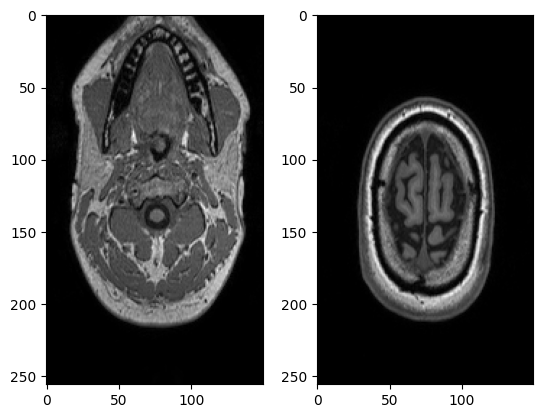

In [9]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_data[:, 30, :], cmap="gray")
axis[1].imshow(brain_mri_data[:, 200, :], cmap="gray")


And finally we slice through the third axis which moves from the right ear to the left ear. <br />
**Sagital view**

Please take a moment and think about why the head is rotated.

The reason is that, on the first axis of this slice (y axis in the figure) we move from front to back.
If we swap the two axis then the plot would look as we'd imagine it to look like (but again upside down, because we slice from bottom to top)



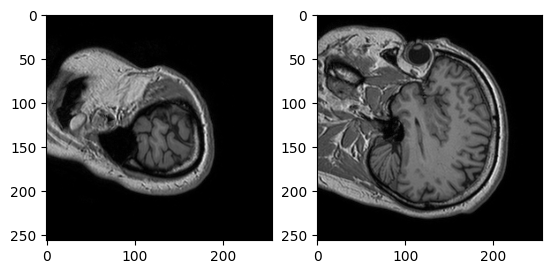

In [10]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_data[:, :, 20], cmap="gray")
axis[1].imshow(brain_mri_data[:, :, 45], cmap="gray")


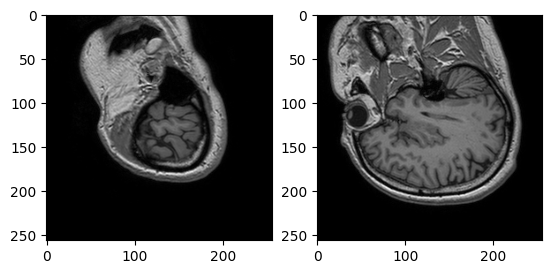

In [11]:
fig, axis = plt.subplots(1, 2)

brain_mri_swapped = np.swapaxes(brain_mri_data, 0, 1)
axis[0].imshow(brain_mri_swapped[:, :, 20], cmap="gray")
axis[1].imshow(brain_mri_swapped[:, :, 45], cmap="gray")


You can use np.flip(arr, axis) to flip the axis and thus changes the orientation to top->bottom.<br />
**CAUTION: This does not change the affine matrix and must only be used for validation purposes**

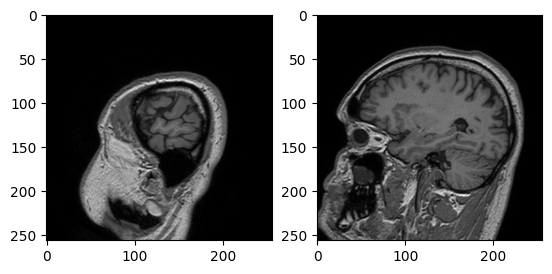

In [12]:
fig, axis = plt.subplots(1, 2)

axis[0].imshow(np.flip(brain_mri_swapped, 0)[:, :, 20], cmap="gray")
axis[1].imshow(np.flip(brain_mri_swapped, 0)[:, :, 100], cmap="gray")


Now let us take a look at the calculations needed to transform coordinates between the coordinate systems.

As an example, if we want to calculate the physical coordinates of the offset, i.e where the voxel coordinates (0,0,0) lie in the physical space, you simply multiply the affine matrix with those coordinates.

Note that we append the 1 for convienience to work with the 4x4 matrix

In [13]:
voxel_coord = np.array((0, 0, 0, 1))
physical_coord0 = affine @ voxel_coord  # @ is a shortcut for matrix multiplication in numpy
print(physical_coord0)

[ -90.67985535  102.82944489 -114.82378387    1.        ]


Remember, this is our affine matrix:

$$\begin{pmatrix}
1.89821944e-02 & -2.72075552e-03 & 1.19975281e+00 & -9.06798553e+01\\
-9.27821696e-01 &  1.32986516e-01 & 2.45456006e-02 & 1.02829445e+02\\
 1.33014351e-01 &  9.28015888e-01 &  5.71511449e-11 & -1.14823784e+02\\
 0.00000000e+00 &  0.00000000e+00 &  0.00000000e+00 & 1.00000000e+00\\
\end{pmatrix}
$$

When computing the matrix multiplication we effectively calculate the following products:
$$ 1.89e-02 * 0 + -2.7e-03 * 0 + 1.19 * 0 + (-9.06e+01) = -9.06e01 = -90.67$$
$$ -9.27e-01 * 0 +  1.32e-01 * 0 + 2.45e-02 * 0 + 1.028e+02 = 102.8$$
$$  1.33e-01 * 0 +  9.2e-01 * 0 5.71e-11 *0 + (-1.14e+02) = -114.82 $$
$$ 0*0 + 0*0 + 0*0 +1+1 = 1$$

As you can see incorporating the 4th column and row enables this shortcut.

You can of course also skip the shortcut and compute the result by hand. To do so you extract the $3\times 3$ sub matrix and multiply it with the voxel_coordinates. Subsequently you add the translation vector (without the last 1)

In [14]:
voxel_coord_manual = np.array((0, 0, 0))
physical_coord_manual = affine[:3, :3] @ voxel_coord_manual
physical_coord_manual = physical_coord_manual + affine[:3,3]
print(physical_coord_manual)

[ -90.67985535  102.82944489 -114.82378387]


If you want to transform physical coordinates into pixel/voxel coordinates you need to compute the inverse of the affine matrix (**np.linalg.inv(arr)** and then multiply this inverse with the physical coordinates.
As an example, if we want to get the voxel coordinates of our offset<br /> ( -90.67985535  102.82944489 -114.82378387
) we need to perform the following calculation:

In [15]:
voxel_coords = (np.linalg.inv(affine) @ physical_coord0).round()
print(voxel_coords)

[-0.  0.  0.  1.]


## Excursion: Reorientation

If you want, you can reorient the volume to RAS by using **nibabel.as_closest_canonical(nifti)**<br />
This is also called canonical orientation

In [16]:
brain_mri_canonical = nib.as_closest_canonical(brain_mri)
brain_mri_canonical_data = brain_mri_canonical.get_fdata()

In [17]:
canonical_affine = brain_mri_canonical.affine
print(affine)
print("----")
print(canonical_affine)
print(nib.aff2axcodes(canonical_affine))

[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
----
[[ 1.19975281e+00 -1.89821944e-02 -2.72075552e-03 -8.58393958e+01]
 [ 2.45456006e-02  9.27821696e-01  1.32986516e-01 -1.33765088e+02]
 [ 5.71511449e-11 -1.33014351e-01  9.28015888e-01 -8.09051243e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
('R', 'A', 'S')


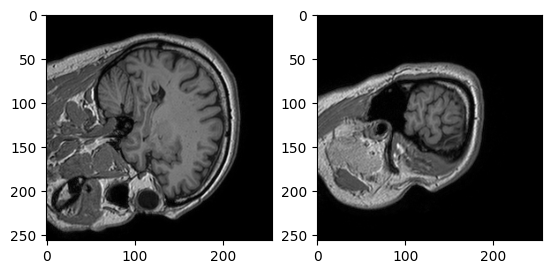

In [18]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_canonical_data[50, :, :], cmap="gray")
axis[1].imshow(brain_mri_canonical_data[130, :, :], cmap="gray")


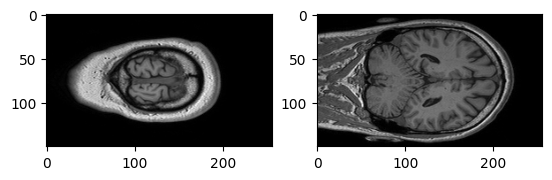

In [19]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_canonical_data[:, 40, :], cmap="gray")
axis[1].imshow(brain_mri_canonical_data[:, 90, :], cmap="gray")


<IPython.core.display.Javascript object>


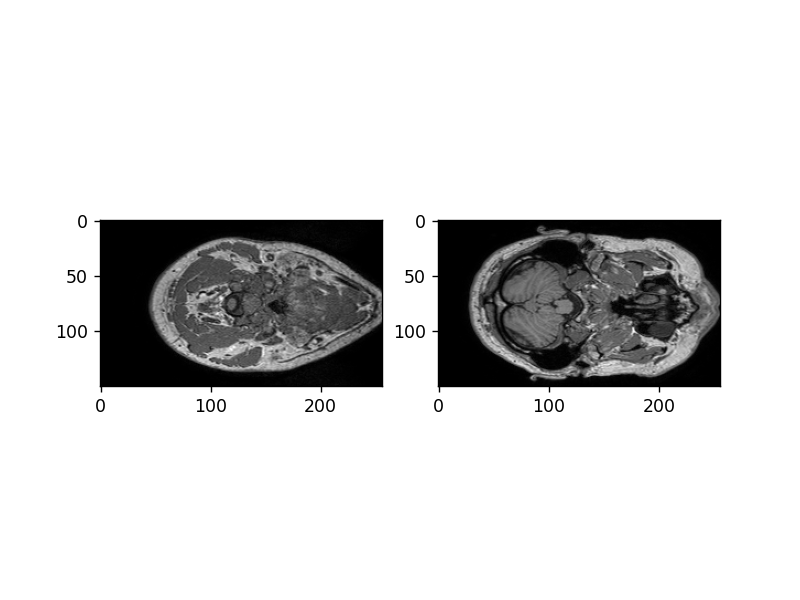

In [19]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_canonical_data[:, :, 5], cmap="gray")
axis[1].imshow(brain_mri_canonical_data[:, :, 70], cmap="gray")


# Resampling

Let's resize our brain mri from (256, 256, 150) to (128, 128, 100)

In [20]:
print(brain_mri.shape)
print(brain_mri.header.get_zooms())

(256, 256, 150)
(np.float32(0.9375), np.float32(0.9375), np.float32(1.2000039))


To do so, you can use **conform(input, desired_shape, voxel_size)** from nibabel.processing which resamples the image to the desired shape.
Note that you have to change the voxel size as otherwise it would become impossible to reduce the size!
Let's simply use a voxel size of $(2 \times 2 \times 2)$mm

In [21]:
import nibabel.processing

In [22]:
voxel_size = (2, 2, 2)
brain_mri_resized = nibabel.processing.conform(brain_mri, (128, 128, 100), voxel_size, orientation="PSR")
brain_mri_resized_data = brain_mri_resized.get_fdata()

In [23]:
print(brain_mri.shape)
print(brain_mri_resized.shape)
print(brain_mri_resized.header.get_zooms())

(256, 256, 150)
(128, 128, 100)
(np.float32(2.0), np.float32(2.0), np.float32(2.0))


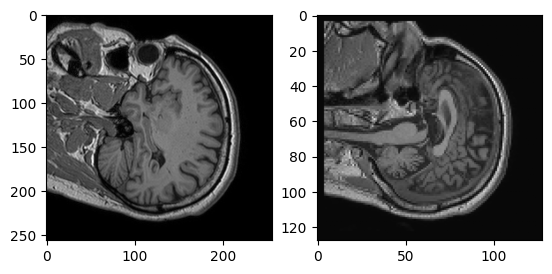

In [24]:
IDX = 50
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_mri_data[:,:,IDX], cmap="gray")
axis[1].imshow(brain_mri_resized_data[:,:,IDX], cmap="gray")


## Normalization and standardization

The last section in this notebook will demonstrate different data normalization/standardization routines for both, ct and mri images.



## CT

As CTs have a fixed scale from -1000 (air) to 1000 (water) (This is called Houndsfield unit) you normally do not perform normalization to keep those scales.

In practice, we can assume that the values are between -1024 and 3071.

Thus we can standardize the data by dividing the volume by 3071.

In [25]:
lung_ct = nib.load("lung_043.nii.gz")
lung_ct_data = lung_ct.get_fdata()

In [26]:
lung_ct_data_standardized = lung_ct_data / 3071

Note that the standardized CT looks identical not the original one

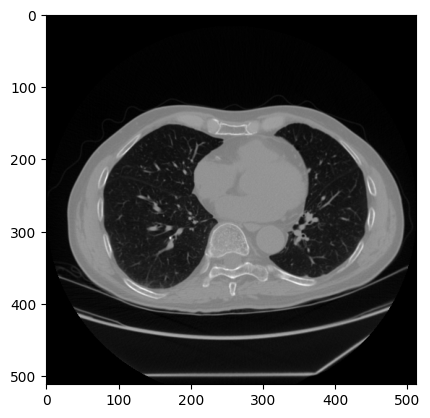

In [27]:
plt.figure()
plt.imshow(np.rot90(lung_ct_data_standardized[:,:,50]), cmap="gray")

## Windowing:

Depending on the task we perform we want to have a different contrast.<br />
As an example, if you want to inspect the lung it is important to be able to view all small vessels.<br />
In contrast, when examining the body it is important to have a high contrast, to be able to differentiate between different tissues.

This change in contrast is called windowing.<br />
There are typically four different windows, a lung window, a bone window,  a soft-tissue window and a brain window.<br />
You can create such a window, by clipping all pixel values larger than a threshold.

Let's take a look at the lung- and the soft-tissue window.


To get a nice lung window, you can clip all values larger than -500 to -500. Note that this window completely denies us to take a look at the abdomen as everything looks identical.

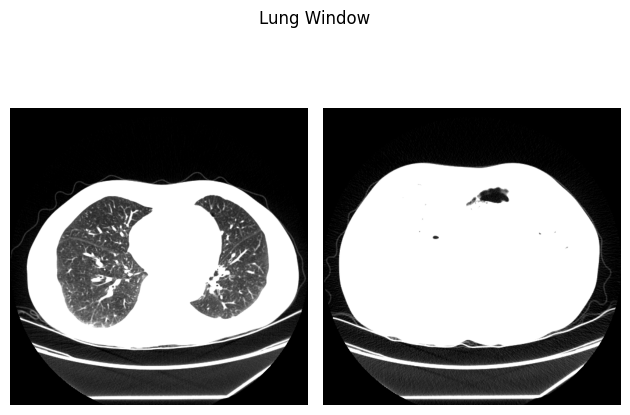

In [28]:
lung_ct_lung_window = np.clip(lung_ct_data, -1000, -500)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(np.rot90(lung_ct_lung_window[:,:,50]), cmap="gray")
axis[1].imshow(np.rot90(lung_ct_lung_window[:,:,5]), cmap="gray")
axis[0].axis("off")
axis[1].axis("off")
fig.suptitle("Lung Window")
plt.tight_layout()
plt.savefig("lung_window.png", bbox_inches="tight")


To get a nice soft-tissue window, you can clip all values in bweteen -250 and 250. Here the lung ist almost black but you have a nice image of the abdomen.

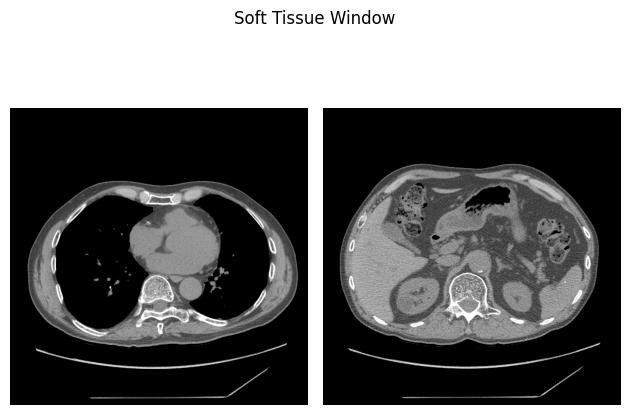

In [29]:
lung_ct_soft_tissue_window = np.clip(lung_ct_data, -250, 250)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(np.rot90(lung_ct_soft_tissue_window[:,:,50]), cmap="gray")
axis[1].imshow(np.rot90(lung_ct_soft_tissue_window[:,:,5]), cmap="gray")

axis[0].axis("off")
axis[1].axis("off")
fig.suptitle("Soft Tissue Window")
plt.tight_layout()
plt.savefig("tissue_window.png", bbox_inches="tight")


## MRI
In contrast to CTs MRI images do not have an absolute, fixed scale and each patient varies.

Thus you can z-normalize the scans in a patient-wise manner.

$$ X_{\text{norm}} = \frac{X - \mu}{\sigma}$$

Additionally you can perform min-max scaling.
$$X_{\text{standardized}} = \frac{X - min(X)}{max(X)-min(X)} $$


In [30]:
cardiac_mri = nib.load("la_003.nii.gz")
cardiac_mri_data = cardiac_mri.get_fdata()

In [31]:
mean, std = np.mean(cardiac_mri_data), np.std(cardiac_mri_data)
cardiac_mri_norm = (cardiac_mri_data - mean) / std
cardiac_mri_standardized = (cardiac_mri_norm - np.min(cardiac_mri_norm)) / (np.max(cardiac_mri_norm) - np.min(cardiac_mri_norm))

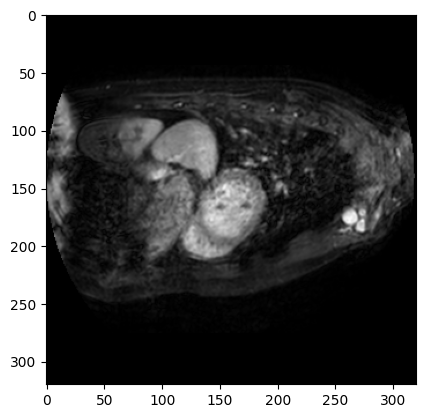

In [32]:
plt.figure()
plt.imshow(cardiac_mri_standardized[:,:,30], cmap="gray")

Typically there is no windowing in MRI scans.